In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import re
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import WeightedRandomSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
batch_size = 102400
down_scaled_dim = 200
epochs=100
lr = 3e-3
train_size = 80000
eval_size = 2000
eval_iters = train_size * 64 // (batch_size * 2)

In [3]:
# def fen_from_filename(filename):
#     base = os.path.basename(filename)
#     return os.path.splitext(base)[0]

def fen_from_filename(filename):
    return filename.split('.')[0]

In [4]:
fen_parent = './fen_dataset'
train_path = os.path.join(fen_parent, "train")
eval_path = os.path.join(fen_parent, "eval")
train_set = os.listdir(train_path)
eval_set = os.listdir(eval_path)

random.shuffle(train_set)
random.shuffle(eval_set)

train_set = train_set[:train_size]
eval_set = eval_set[:eval_size]

print(fen_from_filename(train_set[0]))
print(fen_from_filename(train_set[1]))
print(fen_from_filename(eval_set[2]))

1Kr5-3R4-1Q2k3-8-3n4-5P2-8-8
8-2pp1K2-6pn-6k1-7Q-8-8-7Q
Nrb2R2-1P6-2n5-4K3-2b2p2-8-1P5k-4b3


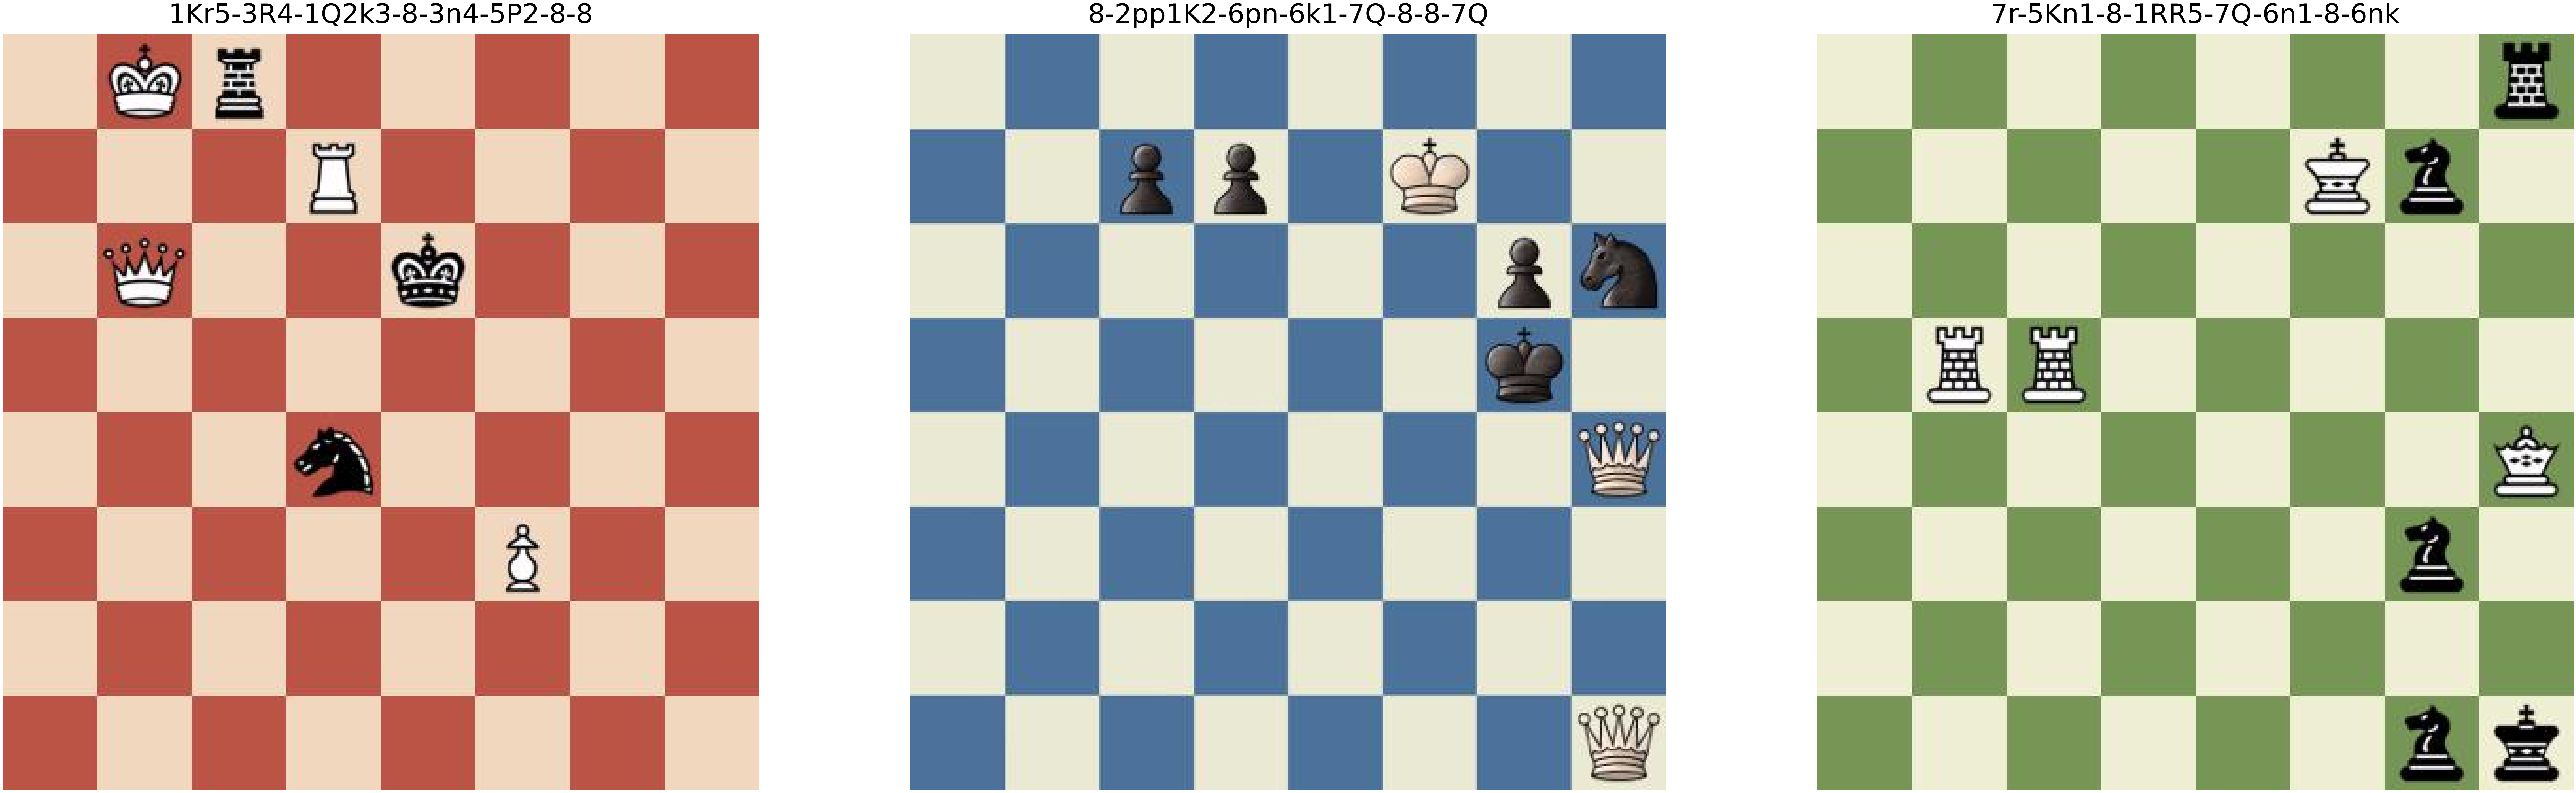

In [5]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(fen_from_filename(train_set[i]), fontsize=70, pad=30)
    axarr[i].imshow(Image.open(os.path.join(train_path, train_set[i])))
    axarr[i].axis('off')

plt.show()

In [6]:
# import cv2

# def crop_image_into_squares(image_array, num_squares_per_side=8):
#     height, width, _ = image_array.shape
#     square_size = min(height, width) // num_squares_per_side

#     cropped_squares = image_array.reshape(num_squares_per_side, square_size,
#                                           num_squares_per_side, square_size, 3)
#     print(cropped_squares.shape)
#     cropped_squares = cropped_squares.swapaxes(1, 2).reshape(-1, square_size, square_size, 3)
#     print(cropped_squares.shape)

#     return cropped_squares

# def process_image(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (200, 200))
#     cropped_squares = crop_image_into_squares(img)
#     return cropped_squares


# processed_image = process_image(os.path.join(train_path, train_set[0]))
# num_squares = len(processed_image)
# fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# for i in range(num_squares):
#     ax = axes[i // 8, i % 8]
#     ax.imshow(processed_image[i])
#     ax.axis('off')

# plt.show()

tensor([-0.2157, -0.3020, -0.3647,  ..., -0.3020, -0.0745, -0.2235])
tensor([])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

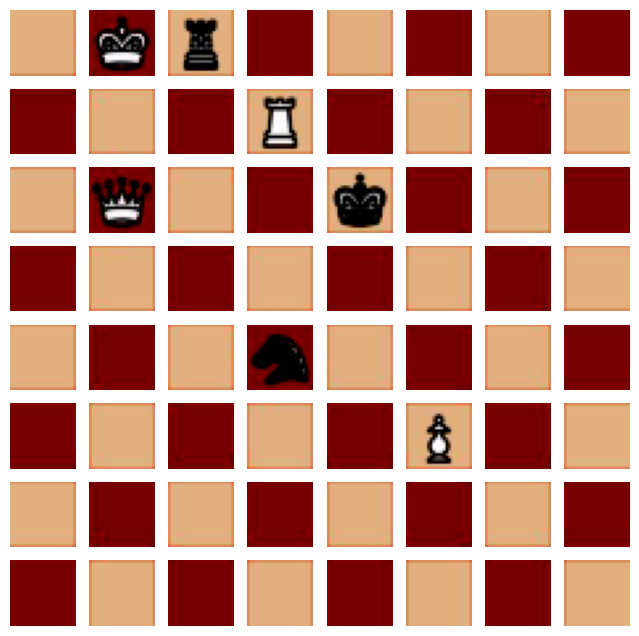

In [7]:
transform = transforms.Compose([ 
    transforms.Resize((down_scaled_dim, down_scaled_dim)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def crop_image_into_squares(images_array, num_squares_per_side=8):
    B, C, height, width = images_array.shape
    square_size = min(height, width) // num_squares_per_side

    cropped_squares = images_array.reshape(B, C, num_squares_per_side, square_size,
                                          num_squares_per_side, square_size)
    cropped_squares = cropped_squares.permute(0, 2, 4, 1, 3, 5)
    cropped_squares = cropped_squares.reshape(B, -1, C, square_size, square_size)

    return cropped_squares

def process_images(img_paths, device):
    imgs = torch.stack([transform(Image.open(img_path)).to(device) for img_path in img_paths])
    cropped_squares = crop_image_into_squares(imgs)
    return cropped_squares


processed_image = process_images([os.path.join(train_path, train_set[0])], device="cpu")[0]
print(processed_image[1].permute(1, 2, 0)[processed_image[1].permute(1, 2, 0) < 0])
print(processed_image[1].permute(1, 2, 0)[processed_image[1].permute(1, 2, 0) > 1])
num_squares = len(processed_image)
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i in range(num_squares):
    ax = axes[i // 8, i % 8]
    ax.imshow(processed_image[i].permute(1, 2, 0))
    ax.axis('off')

plt.show()

In [8]:
def onehot_from_fen(fen):
    eye = torch.eye(13, device=device)
    output = torch.empty((0, 13), device=device)
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = torch.cat((output, torch.tile(eye[12], (int(char), 1))), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = torch.cat((output, eye[idx].reshape((1, 13))), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            idx = torch.where(one_hot[j][i] == 1)[0][0]

            if(idx == 12):
                output += ' '
            else:
                output += piece_symbols[idx]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output


piece_symbols = 'prbnkqPRBNKQ'
fen = "4K3-4P3-8-8-PP6-8-1R3rn1-5bk1"
fen_from_onehot(onehot_from_fen(fen).reshape(8, 8, 13))

'4K3-4P3-8-8-PP6-8-1R3rn1-5bk1'

In [9]:
def get_balanced_mask(labels):
    class_counts = torch.sum(labels, dim=0)

    total_samples = class_counts.sum()
    class_weights = torch.zeros(class_counts.shape, device=device)
    class_weights[class_counts > 0] = total_samples / class_counts[class_counts > 0]

    modified_labels = torch.where(labels == 1)[1]

    weights = class_weights[modified_labels]
    weighted_sampler = WeightedRandomSampler(weights, labels.shape[0], replacement=True)

    return list(weighted_sampler)

In [10]:
def get_batches(data, batch_size, down_scaled_dim, train_path, device):
    num_samples = len(data)
    square_size = down_scaled_dim // 8
    batch_size = batch_size // 64

    # Define a generator function to yield batches
    def batch_generator():
        for i in range(0, num_samples, batch_size):
            batch_data = data[i:i+batch_size]

            # Process labels
            batch_labels = torch.stack([onehot_from_fen(fen_from_filename(file)) for file in batch_data]).reshape(-1, 13)
            balanced_mask = get_balanced_mask(labels= batch_labels)
            batch_labels = batch_labels[balanced_mask]

            # Process photos
            batch_photos = process_images([os.path.join(train_path, file) for file in batch_data], device).reshape(-1, 3, square_size, square_size)
            batch_photos = batch_photos[balanced_mask]

            yield batch_photos, batch_labels

    return batch_generator()

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(144, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 13)
        self.dropout = nn.Dropout(0.2)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0, std=0.01)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


cnn = CNN()
cnn = cnn.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(cnn.parameters(), lr=lr)


In [13]:
@torch.no_grad()
def estimate_eval_loss():
    cnn.eval()
    batch_iterator = get_batches(eval_set, batch_size, down_scaled_dim, eval_path, device)
    running_loss = 0.0
    for data in batch_iterator:
        inputs, labels = data
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    cnn.train()
    return running_loss

In [15]:
for epoch in range(epochs):
    batch_iterator = get_batches(train_set, batch_size, down_scaled_dim, train_path, device)

    running_loss = 0.0
    for i, data in enumerate(batch_iterator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % eval_iters == eval_iters - 1:
            eval_loss = estimate_eval_loss()
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / eval_iters:.5f} eval_loss: {eval_loss:.5f}')
            running_loss = 0.0

# last Epoch [21,    50] loss: 0.00554 eval_loss: 0.00017
# nope [1,    50] loss: 0.00542 eval_loss: 0.00015
print('Finished Training')

[1,    25] loss: 0.00556 eval_loss: 0.00018
[1,    50] loss: 0.00542 eval_loss: 0.00019
[2,    25] loss: 0.00540 eval_loss: 0.00018
[2,    50] loss: 0.00542 eval_loss: 0.00019
[3,    25] loss: 0.00541 eval_loss: 0.00019
[3,    50] loss: 0.00544 eval_loss: 0.00018
[4,    25] loss: 0.00544 eval_loss: 0.00018
[4,    50] loss: 0.00534 eval_loss: 0.00019


KeyboardInterrupt: 

In [ ]:
PATH = './fen_models/102400_batch_3e-3_lr_last.pth'
torch.save(cnn.state_dict(), PATH)

In [14]:
# PATH = './fen_models/102400_batch_3e-3_lr_best.pth'
# cnn = CNN()
# cnn.load_state_dict(torch.load(PATH))
# cnn = cnn.to(device)

In [15]:
estimate_eval_loss()

0.00016571518062846735

In [18]:
processed_image = process_images([os.path.join(eval_path, eval_set[0])], device)[0]
outputs = cnn(processed_image)
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  7, 12, 12, 12, 12, 12,
        12, 12, 11, 12, 12,  2, 12, 12, 12, 12, 12, 12,  2, 12, 12, 12, 12, 12,
         4,  0,  0,  3, 12, 12, 12, 12,  9, 12,  7, 12,  0, 12, 12, 12, 12, 12,
         0, 12, 10, 12, 12, 12, 12, 12, 12, 12], device='cuda:0')


In [19]:
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

fen_from_onehot(predicted.reshape(8, 8)), fen_from_filename(eval_set[0])

('8-4R3-4Q2b-6b1-4kppn-4N1R1-p5p1-K7', '8-4R3-4Q2b-6b1-4kppn-4N1R1-p5p1-K7')